# SM2 – ThermoPro: Top senzory podle počtu záznamů (box ploty teplot)

Notebook stáhne veřejný **SM2** dataset (Parquet), vybere **ThermoPro** senzory (podle `location`) s **největším množstvím dat** pro `temp_indoor` a vykreslí **box grafy** rozdělení teplot pro špičkové senzory.

**Poznámky:**
- Data: kompletní historie (bez dodatečného čištění/odstraňování outlierů).
- Metrika: `temp_indoor` (°C) z `ThermoPro`.
- Grafy jsou uloženy i do `plots/` jako PNG.


In [2]:
try:
    import pandas as pd
    import matplotlib
except Exception:
    %pip install -q pandas pyarrow matplotlib gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

plt.rcParams['figure.figsize'] = (12, 6)


In [3]:
# Google Drive IDs (veřejné)
PARQUET_ID = "1gLPWgUGtRb371Gpv5O8t5j95lthNjELg"  # sm2_public_dataset.parquet
CSVGZ_ID  = "1eLOAOZ13--EKE63GZhmerjmY9zkeJcyd"  # sm2_public_dataset.csv.gz (fallback)
USE_PARQUET = True

parquet_path = Path("sm2_public_dataset.parquet")
csvgz_path   = Path("sm2_public_dataset.csv.gz")

def gdown_download(file_id: str, out_path: Path):
    import subprocess, sys
    try:
        import gdown  # type: ignore
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gdown"])  # noqa
        import gdown  # type: ignore
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, str(out_path), quiet=False)

if USE_PARQUET:
    if not parquet_path.exists():
        print("Stahuji Parquet…")
        gdown_download(PARQUET_ID, parquet_path)
else:
    if not csvgz_path.exists():
        print("Stahuji CSV.GZ…")
        gdown_download(CSVGZ_ID, csvgz_path)


Stahuji Parquet…


Downloading...
From: https://drive.google.com/uc?id=1gLPWgUGtRb371Gpv5O8t5j95lthNjELg
To: /content/sm2_public_dataset.parquet
100%|██████████| 1.29M/1.29M [00:00<00:00, 64.8MB/s]


In [4]:
# Načtení dat a příprava
if USE_PARQUET and parquet_path.exists():
    df = pd.read_parquet(parquet_path)
elif csvgz_path.exists():
    df = pd.read_csv(csvgz_path, compression="gzip")
else:
    raise FileNotFoundError("Dataset nebyl stažen – zkontrolujte připojení a ID souboru.")

df['time'] = pd.to_datetime(df['time'], utc=True, errors='coerce')
df['data_value'] = pd.to_numeric(df['data_value'], errors='coerce')

# Filtrace na ThermoPro / temp_indoor
tp = df[(df['source'] == 'ThermoPro') & (df['data_key'] == 'temp_indoor')].copy()
print(f"ThermoPro temp_indoor – celkem řádků: {len(tp):,}")

# Počty záznamů podle senzoru (location)
counts = tp.groupby('location', as_index=False).size().sort_values('size', ascending=False)
counts.rename(columns={'size':'rows'}, inplace=True)
counts.head(20)


ThermoPro temp_indoor – celkem řádků: 10,630


,location,rows
9,1PP-S1,2289
20,5NP-S3,2122
24,5NP-S7,678
22,5NP-S5,677
14,2PP-S9,673
17,3PP-S9,673
15,3PP-S5,570
12,2PP-S1,570
23,5NP-S6,311
26,5NP-S9,310


Top senzory: ['1PP-S1', '5NP-S3', '5NP-S7', '5NP-S5', '2PP-S9', '3PP-S9', '3PP-S5', '2PP-S1', '5NP-S6', '5NP-S9', '5NP-S8', '5NP-S2']


/tmp/ipython-input-362333730.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_lists, labels=top_locations)


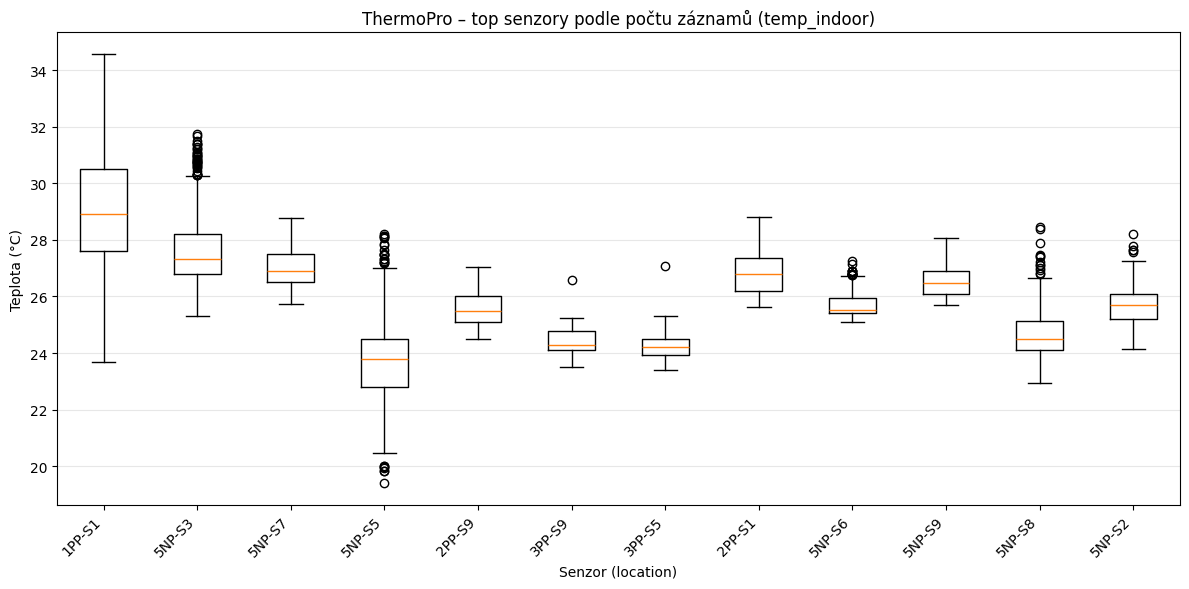

✅ Uloženo: plots/ThermoPro_top_sensors_boxplot_temp_indoor.png


In [5]:
# Výběr top-K senzorů podle množství dat
TOP_K = 12  # změň podle potřeby (např. 6, 9, 12)
top_locations = counts.head(TOP_K)['location'].tolist()
print("Top senzory:", top_locations)

# Data pro boxplot (list of arrays), v pořadí top_locations
data_lists = [tp.loc[tp['location'] == loc, 'data_value'].dropna().values for loc in top_locations]

os.makedirs('plots', exist_ok=True)

# Boxplot teplot pro top senzory
fig = plt.figure()
ax = plt.gca()
ax.boxplot(data_lists, labels=top_locations)
ax.set_title("ThermoPro – top senzory podle počtu záznamů (temp_indoor)")
ax.set_xlabel("Senzor (location)")
ax.set_ylabel("Teplota (°C)")
plt.xticks(rotation=45, ha='right')
ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("plots/ThermoPro_top_sensors_boxplot_temp_indoor.png", dpi=150)
plt.show()
print("✅ Uloženo: plots/ThermoPro_top_sensors_boxplot_temp_indoor.png")


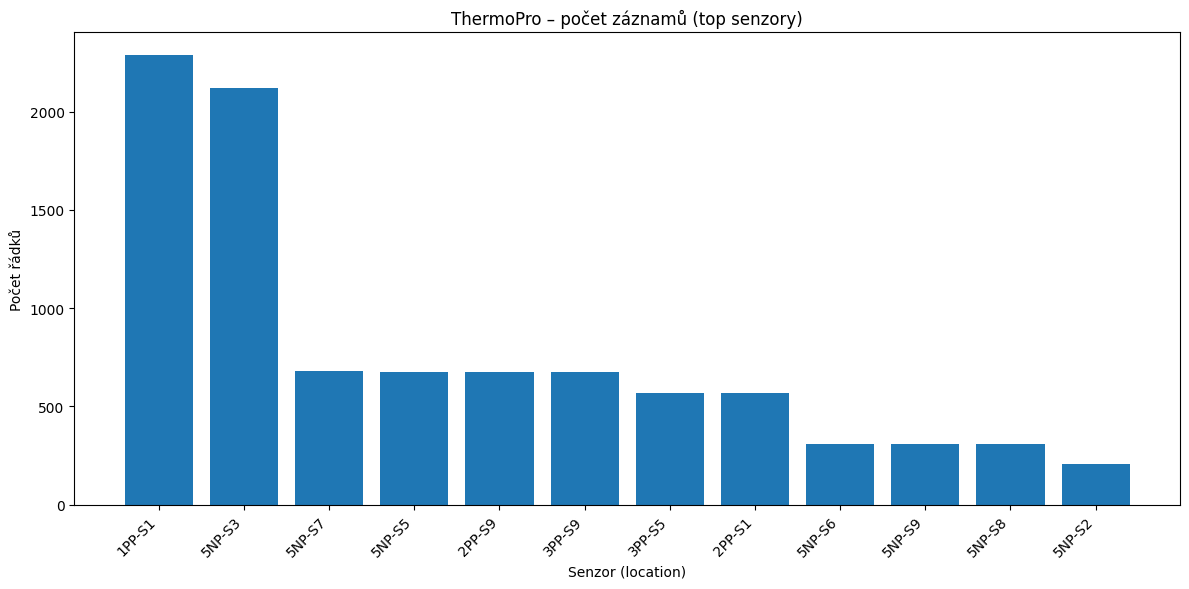

✅ Uloženo: plots/ThermoPro_top_sensors_counts.png


In [6]:
# (Volitelné) Přehled: kolik záznamů má každý ze zobrazených senzorů
bar_counts = counts[counts['location'].isin(top_locations)].set_index('location').loc[top_locations]
fig = plt.figure()
ax = plt.gca()
ax.bar(bar_counts.index.astype(str), bar_counts['rows'].values)
ax.set_title("ThermoPro – počet záznamů (top senzory)")
ax.set_xlabel("Senzor (location)")
ax.set_ylabel("Počet řádků")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("plots/ThermoPro_top_sensors_counts.png", dpi=150)
plt.show()
print("✅ Uloženo: plots/ThermoPro_top_sensors_counts.png")
